In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def raDec2Hpid(nside, ra, dec, **kwargs):
    """
    Assign ra,dec points to the correct healpixel.
    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    ra : np.array
        RA values to assign to healpixels. Radians.
    dec : np.array
        Dec values to assign to healpixels. Radians.
    Returns
    -------
    hpids : np.array
        Healpixel IDs for the input positions.
    """
    lat = np.pi / 2.0 - dec
    hpids = hp.ang2pix(nside, lat, ra, **kwargs)
    return hpids

In [11]:
def healbin(ra, dec, values, nside=128, reduceFunc=np.mean, dtype=float, fillVal=hp.UNSEEN):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.
    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Radians.
    dec : np.array
        Dec positions of the data points. Radians
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduceFunc : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.
    """

    hpids = raDec2Hpid(nside, ra, dec)

    order = np.argsort(hpids)
    hpids = hpids[order]
    values = values[order]
    pixids = np.unique(hpids)

    left = np.searchsorted(hpids, pixids)
    right = np.searchsorted(hpids, pixids, side='right')

    mapVals = np.zeros(hp.nside2npix(nside), dtype=dtype) + fillVal

    # Wow, I thought histogram would be faster than the loop, but this has been faster!
    for i, idx in enumerate(pixids):
        mapVals[idx] = reduceFunc(values[left[i]:right[i]])

    # Change any NaNs to fill value
    mapVals[np.isnan(mapVals)] = fillVal

    return mapVals

In [4]:
def uniformSphere(npoints, seed=42):
    """
    Just make RA, dec points on a sphere
    """
    np.random.seed(seed)
    u = np.random.uniform(size=npoints)
    v = np.random.uniform(size=npoints)

    ra = 2.*np.pi * u
    dec = np.arccos(2.*v - 1.)
    # astro convention of -90 to 90
    dec -= np.pi/2.
    return np.degrees(ra), np.degrees(dec)


In [14]:
ra_deg, dec_deg = uniformSphere(10000)
ra = np.radians(ra_deg)
dec = np.radians(dec_deg)
values =np.random.uniform(size=ra.size)

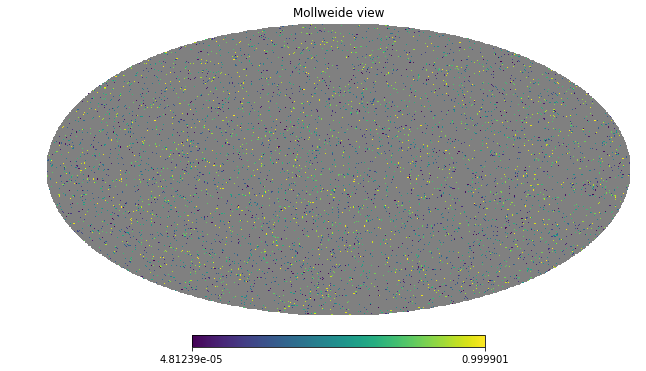

In [16]:
mean_map = healbin(ra, dec, values)
hp.mollview(mean_map)

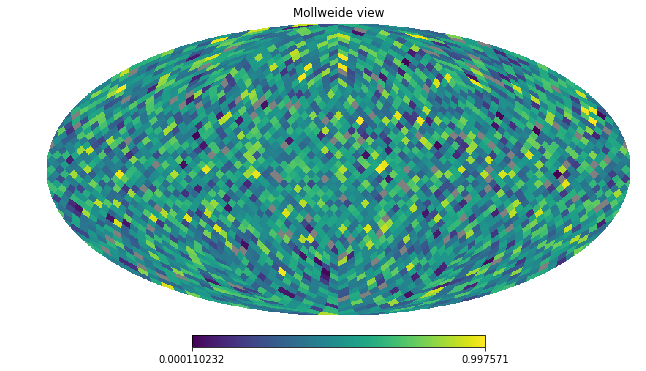

In [18]:
# Same, but at lower resolution
mean_map = healbin(ra, dec, values, nside=16)
hp.mollview(mean_map)

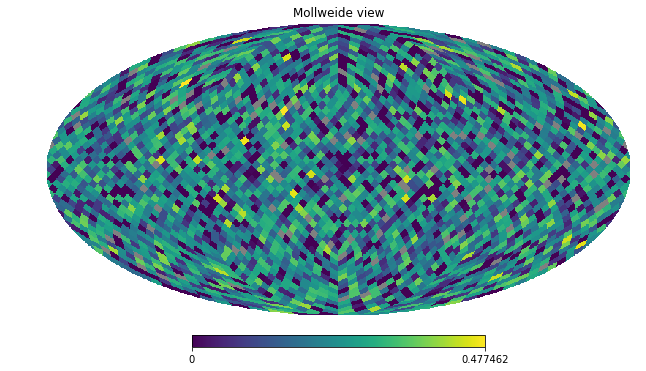

In [19]:
# Now to do a different statistic
mean_map = healbin(ra, dec, values, nside=16, reduceFunc=np.std)
hp.mollview(mean_map)